In [13]:
import tensorflow as tf
from tensorflow.keras import layers,models
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def create_cnn_model(
    input_shape=(32, 32, 3),
    num_classes=10,
    conv_layers=2,
    dense_layers=1,  
    initial_filters=32,
    filter_growth_rate=2,
    learning_rate=0.001
):
    model = models.Sequential()
    
    model.add(layers.Conv2D(initial_filters, (3, 3), activation='relu', input_shape=input_shape))
    
    current_filters = initial_filters
    for _ in range(conv_layers):
        current_filters *= filter_growth_rate
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(current_filters, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    
    for _ in range(dense_layers):
        model.add(layers.Dense(64, activation='relu'))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    return model

In [8]:
def train_cnn_model(
    model,
    x_train,
    y_train,
    x_test,
    y_test
):

    history = model.fit(x_train, y_train, epochs=100, 
                        validation_data=(x_test, y_test))
    return history


In [10]:
x_train = np.load("/home/splintersword/Documents/Computers/Image_Classification/data/raw/x_train.npy")
x_test = np.load("/home/splintersword/Documents/Computers/Image_Classification/data/raw/x_test.npy")
y_train = np.load("/home/splintersword/Documents/Computers/Image_Classification/data/raw/y_train.npy")
y_test = np.load("/home/splintersword/Documents/Computers/Image_Classification/data/raw/y_test.npy")
model = create_cnn_model()
history = train_cnn_model(model,x_train,y_train,x_test,y_test)

print(history)

/home/splintersword/.local/share/virtualenvs/Image_Classification-nc8MtVhL/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1746282786.471482  490938 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-05-03 20:03:06.649073: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153600000 exceeds 10% of free system memory.


Epoch 1/100
1558/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2899 - loss: 2.5919

2025-05-03 20:03:20.918418: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30720000 exceeds 10% of free system memory.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.2902 - loss: 2.5888 - val_accuracy: 0.4959 - val_loss: 1.4074
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5383 - loss: 1.2964 - val_accuracy: 0.5845 - val_loss: 1.1953
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6187 - loss: 1.0890 - val_accuracy: 0.6348 - val_loss: 1.0877
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6705 - loss: 0.9482 - val_accuracy: 0.6430 - val_loss: 1.0532
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7060 - loss: 0.8527 - val_accuracy: 0.6443 - val_loss: 1.0515
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7363 - loss: 0.7588 - val_accuracy: 0.6629 - val_loss: 1.0181
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7608 - loss: 0.6954 - val_accuracy: 0.6570 - val_loss: 1.0634
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7783 - loss: 0.638

In [11]:
def plot_training_history(history):
    """
    Visualize model training performance
    
    Args:
        history: Keras training history object
    """
    plt.figure(figsize=(12, 4))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(model, x_test, y_test):
    """
    Comprehensive model evaluation
    
    Args:
        model: Trained Keras model
        x_test: Test input data
        y_test: Test target data
    
    Returns:
        Performance metrics dictionary
    """
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }

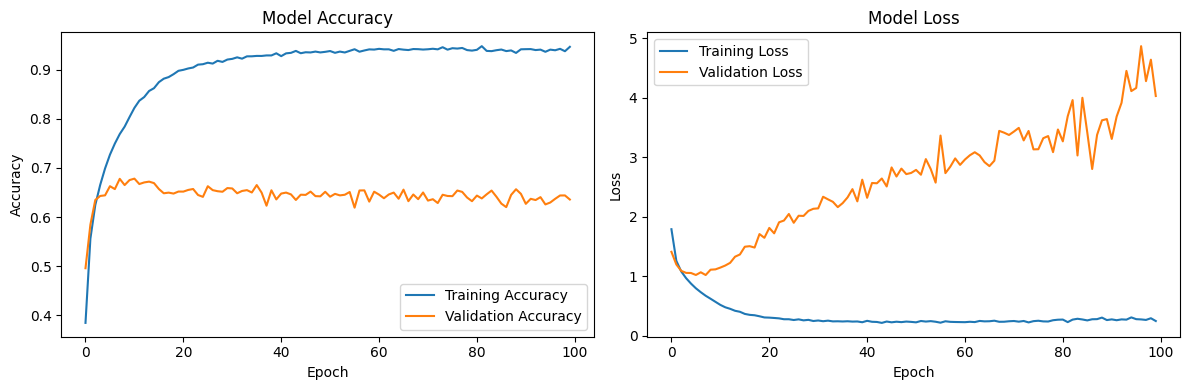

In [14]:
plot_training_history(history)